In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression

### Doing EDA for Macro level analysis

In [66]:
df_micro = pd.read_csv("micro_gait_data (2).csv")

print(df_micro.head())
print(df_micro.shape)

   subject  condition  replication  leg  joint  time     angle       vel  \
0        1          1            1    1      1     0  4.682881  0.390246   
1        1          1            1    1      1     1  5.073127  0.390246   
2        1          1            1    1      1     2  5.229774  0.156647   
3        1          1            1    1      1     3  5.083273 -0.146502   
4        1          1            1    1      1     4  4.652399 -0.430874   

        acc  
0 -0.233599  
1 -0.233599  
2 -0.233599  
3 -0.303149  
4 -0.284372  
(181800, 9)


In [67]:
agg_funcs = {
    'angle': ['mean', 'std', 'min', 'max', 'median'],
    'vel':   ['mean', 'std', 'min', 'max', 'median'],
    'acc':   ['mean', 'std', 'min', 'max', 'median']
}

# Groupping and aggregating for three levels: subject, condition, replication
df_macro = df_micro.groupby(['subject', 'condition', 'replication']).agg(agg_funcs)

# Flattening multi-level column names
df_macro.columns = ['_'.join(col) for col in df_macro.columns]
df_macro = df_macro.reset_index()

print(df_macro.head())
print(df_macro.shape)

   subject  condition  replication  angle_mean  angle_std  angle_min  \
0        1          1            1   11.556532  15.088670 -15.965032   
1        1          1            2   11.737712  15.977920 -17.492003   
2        1          1            3   11.245866  15.614480 -16.231325   
3        1          1            4   11.559372  15.672279 -16.467403   
4        1          1            5   10.845671  15.326024 -16.289473   

   angle_max  angle_median  vel_mean   vel_std   vel_min   vel_max  \
0  62.445295     10.076578  0.005111  1.313081 -4.692793  3.736549   
1  66.191037      9.966763  0.002502  1.343628 -4.588295  3.838199   
2  65.300057      9.633804 -0.002930  1.381403 -4.981104  3.913851   
3  65.802016      9.500972  0.000439  1.391445 -5.020622  3.967097   
4  64.093660      8.749624 -0.002479  1.362299 -4.997249  3.807093   

   vel_median  acc_mean   acc_std   acc_min   acc_max  acc_median  
0   -0.015406  0.000031  0.216960 -0.551270  1.019209   -0.017769  
1   -0.040

In [68]:
print(df_macro.shape)
print(df_macro.info())
print(df_macro.describe().T)
print(df_macro['condition'].value_counts())
print(df_macro['subject'].nunique())


(300, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subject       300 non-null    int64  
 1   condition     300 non-null    int64  
 2   replication   300 non-null    int64  
 3   angle_mean    300 non-null    float64
 4   angle_std     300 non-null    float64
 5   angle_min     300 non-null    float64
 6   angle_max     300 non-null    float64
 7   angle_median  300 non-null    float64
 8   vel_mean      300 non-null    float64
 9   vel_std       300 non-null    float64
 10  vel_min       300 non-null    float64
 11  vel_max       300 non-null    float64
 12  vel_median    300 non-null    float64
 13  acc_mean      300 non-null    float64
 14  acc_std       300 non-null    float64
 15  acc_min       300 non-null    float64
 16  acc_max       300 non-null    float64
 17  acc_median    300 non-null    float64
dtypes: float64(15), int6

              count       mean       std        min        25%        50%  \
subject       300.0   5.500000  2.877080   1.000000   3.000000   5.500000   
condition     300.0   2.000000  0.817861   1.000000   1.000000   2.000000   
replication   300.0   5.500000  2.877080   1.000000   3.000000   5.500000   
angle_mean    300.0  12.149321  1.918961   8.108408  10.569199  12.630363   
angle_std     300.0  15.807799  1.923471  11.600533  13.966774  16.147297   
angle_min     300.0 -14.198070  4.087372 -27.004634 -16.113178 -13.981610   
angle_max     300.0  67.263664  4.709360  54.670088  64.654086  67.907368   
angle_median  300.0   9.481962  2.131782   4.873259   7.598836   9.897745   
vel_mean      300.0  -0.000616  0.007936  -0.028231  -0.005374  -0.000695   
vel_std       300.0   1.288775  0.135351   0.972114   1.186013   1.290617   
vel_min       300.0  -4.547822  0.484155  -5.812411  -4.901341  -4.587114   
vel_max       300.0   3.925163  0.271646   3.200101   3.732659   3.914661   

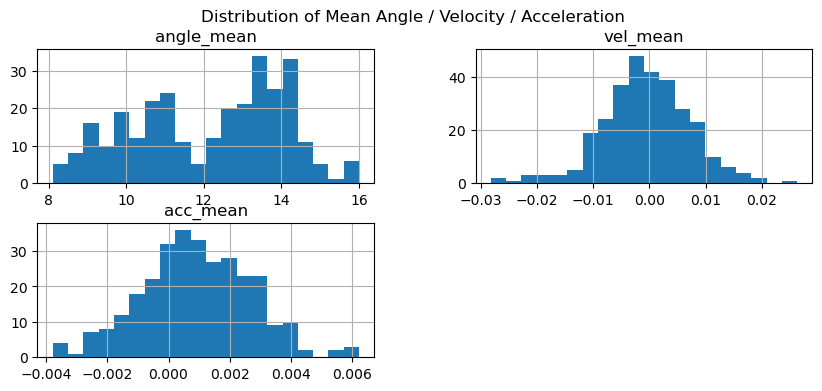

In [69]:
df_macro[['angle_mean', 'vel_mean', 'acc_mean']].hist(bins=20, figsize=(10,4))
plt.suptitle("Distribution of Mean Angle / Velocity / Acceleration")
plt.show()

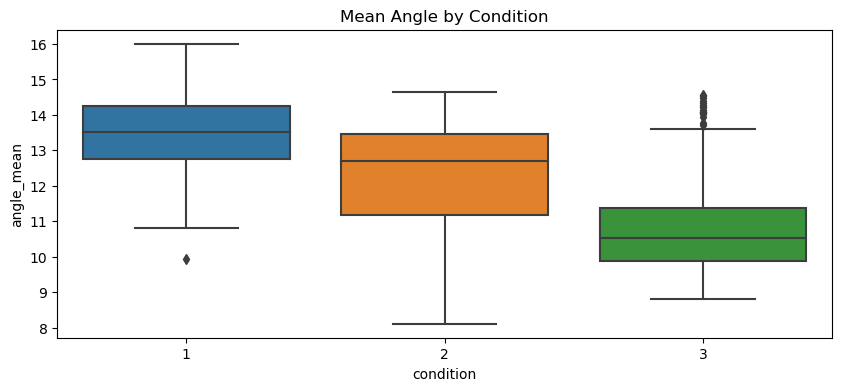

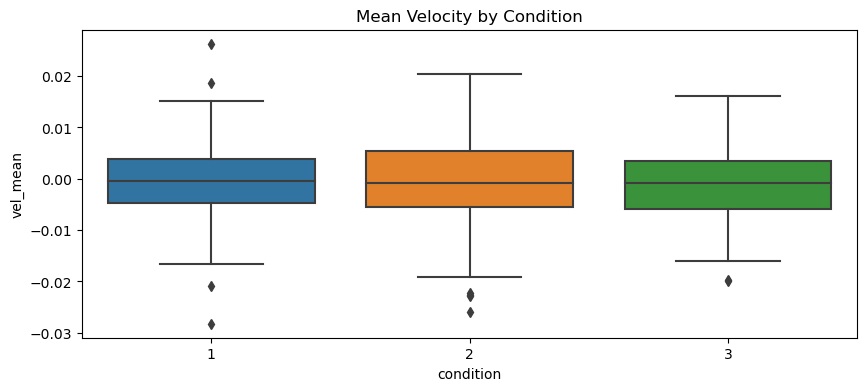

In [70]:
plt.figure(figsize=(10,4))
sns.boxplot(x='condition', y='angle_mean', data=df_macro)
plt.title('Mean Angle by Condition')
plt.show()
     
plt.figure(figsize=(10,4))
sns.boxplot(x='condition', y='vel_mean', data=df_macro)
plt.title('Mean Velocity by Condition')
plt.show()

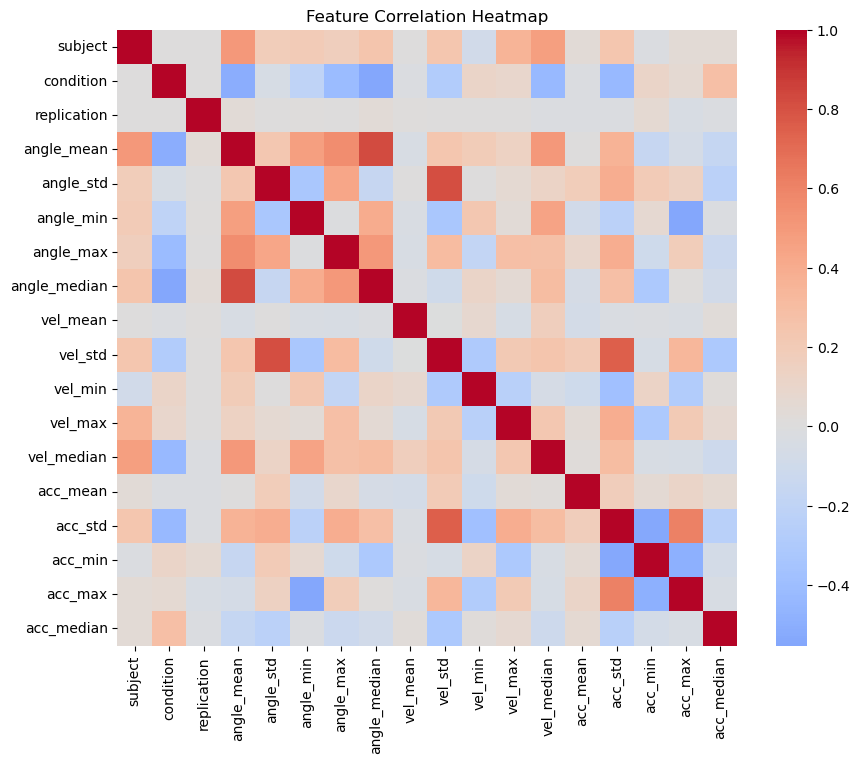

In [71]:
corr = df_macro.select_dtypes(np.number).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

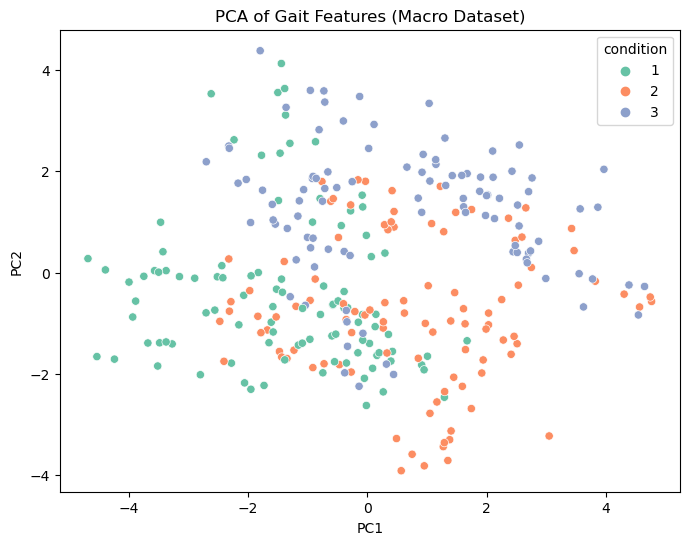

In [72]:
features = [col for col in df_macro.columns if any(k in col for k in ['angle', 'vel', 'acc'])]
X = df_macro[features]
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1],hue=df_macro['condition'], palette='Set2')
plt.title('PCA of Gait Features (Macro Dataset)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


- making cluster for clear visulisation

Silhouette Score (K-Means): 0.144


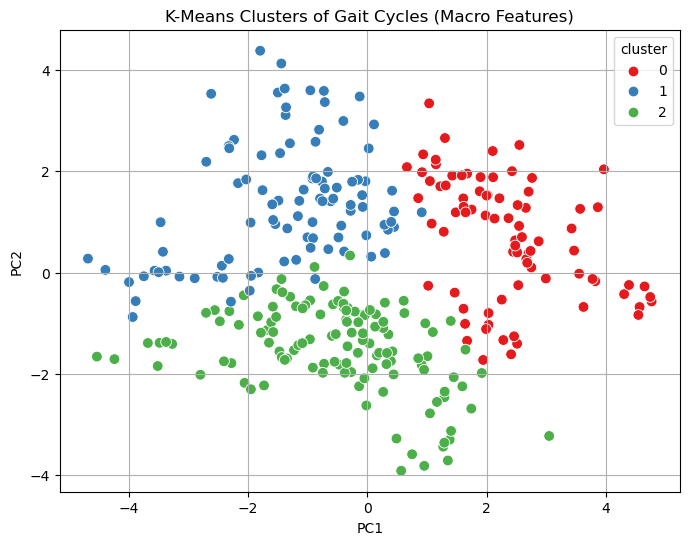


Cluster vs Actual Condition Comparison:
cluster             0   1   2
condition_label              
Ankle Braced       49  39  12
Knee Braced        31  18  51
Normal (No Brace)   1  38  61


In [73]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_macro['cluster'] = kmeans.fit_predict(X_scaled)

# Cluster Quality 
sil_score = silhouette_score(X_scaled, df_macro['cluster'])
print(f"Silhouette Score (K-Means): {sil_score:.3f}")

# Visualizing Clusters in PCA Space
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df_macro['cluster'], palette='Set1', s=60)
plt.title("K-Means Clusters of Gait Cycles (Macro Features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Comparing K-Means Clusters vs. Real Conditions
condition_map = {1: 'Normal (No Brace)', 2: 'Knee Braced', 3: 'Ankle Braced'}
df_macro['condition_label'] = df_macro['condition'].map(condition_map)

comparison = pd.crosstab(df_macro['condition_label'], df_macro['cluster'])
print("\nCluster vs Actual Condition Comparison:")
print(comparison)

# Labeling Each Cluster Based on Dominant Condition ---
dominant_labels = comparison.idxmax(axis=0).to_dict()
df_macro['cluster_label'] = df_macro['cluster'].map(dominant_labels)

In [74]:
purity = []
for c in comparison.columns:
    purity.append((comparison[c].max() / comparison[c].sum()) * 100)
print("\nCluster Purity (% of dominant condition in each cluster):")
for i, p in enumerate(purity):
    print(f"Cluster {i}: {p:.1f}% pure")


Cluster Purity (% of dominant condition in each cluster):
Cluster 0: 60.5% pure
Cluster 1: 41.1% pure
Cluster 2: 49.2% pure


In [75]:
df = df_macro.copy()

# Range (mobility span)
df['angle_range'] = df['angle_max'] - df['angle_min']
df['vel_range']   = df['vel_max']   - df['vel_min']
df['acc_range']   = df['acc_max']   - df['acc_min']

# Motion energy (overall dynamic activity)
df['motion_energy'] = np.sqrt(df['vel_std']**2 + df['acc_std']**2)

# Coefficient of variation
eps = 1e-8  # to avoid divide-by-zero
df['angle_cv'] = df['angle_std'] / (np.abs(df['angle_mean']) + eps)
df['vel_cv']   = df['vel_std']   / (np.abs(df['vel_mean']) + eps)
df['acc_cv']   = df['acc_std']   / (np.abs(df['acc_mean']) + eps)

# Smoothness metric (ratio of velocity to acceleration variability)
df['smoothness'] = df['vel_std'] / (df['acc_std'] + eps)

# Combine movement ranges into a single activity index
df['activity_index'] = (df['angle_range'] + df['vel_range'] + df['acc_range']) / 3

# Quick check
print("Added derived features:")
print(['angle_range','vel_range','acc_range','motion_energy',
       'angle_cv','vel_cv','acc_cv','smoothness','activity_index'])

print("\nNew shape:", df.shape)
display(df)

# Updating main macro dataframe
df_macro = df

Added derived features:
['angle_range', 'vel_range', 'acc_range', 'motion_energy', 'angle_cv', 'vel_cv', 'acc_cv', 'smoothness', 'activity_index']

New shape: (300, 30)


,subject,condition,replication,angle_mean,angle_std,angle_min,angle_max,angle_median,vel_mean,vel_std,...,cluster_label,angle_range,vel_range,acc_range,motion_energy,angle_cv,vel_cv,acc_cv,smoothness,activity_index
0,1,1,1,11.556532,15.088670,-15.965032,62.445295,10.076578,0.005111,1.313081,...,Ankle Braced,78.410327,8.429342,1.570479,1.330884,1.305640,256.923419,7062.093730,6.052189,29.470049
1,1,1,2,11.737712,15.977920,-17.492003,66.191037,9.966763,0.002502,1.343628,...,Ankle Braced,83.683040,8.426494,1.564138,1.360903,1.361247,536.997995,234.847403,6.216204,31.224557
2,1,1,3,11.245866,15.614480,-16.231325,65.300057,9.633804,-0.002930,1.381403,...,Ankle Braced,81.531381,8.894955,1.625710,1.401832,1.388464,471.426647,82.998699,5.793258,30.684015
3,1,1,4,11.559372,15.672279,-16.467403,65.802016,9.500972,0.000439,1.391445,...,Ankle Braced,82.269419,8.987719,1.572941,1.410748,1.355807,3171.374334,1128.637641,5.982880,30.943359
4,1,1,5,10.845671,15.326024,-16.289473,64.093660,8.749624,-0.002479,1.362299,...,Ankle Braced,80.383133,8.804343,1.599846,1.381914,1.413101,549.592565,174.118456,5.871671,30.262440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,10,3,6,9.955452,15.138919,-12.876527,56.064845,6.353700,-0.008585,1.291732,...,Ankle Braced,68.941372,8.160000,1.704634,1.308880,1.520666,150.469879,263.199188,6.116782,26.268669
296,10,3,7,9.711636,15.471280,-13.976071,57.292146,6.105589,0.002824,1.305870,...,Ankle Braced,71.268218,8.223277,1.547093,1.321654,1.593066,462.450661,544.394381,6.412399,27.012862
297,10,3,8,9.567809,15.602417,-13.388878,56.875396,5.525612,0.002815,1.318761,...,Ankle Braced,70.264274,8.187065,1.349251,1.334717,1.630720,468.473645,127.218381,6.409134,26.600197
298,10,3,9,10.058331,15.218115,-12.405920,54.774227,6.868631,0.001472,1.272888,...,Ankle Braced,67.180148,7.801039,1.428641,1.289066,1.512986,864.771296,342.933082,6.252255,25.469943


In [76]:
df = df_macro.copy()

# Encoding categorical variables
cat_cols = ['subject', 'condition', 'replication']
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Selecting numeric features for scaling
num_cols = df.select_dtypes(include=[np.number]).columns.drop(cat_cols)

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# just for checking
print("Scaled & encoded columns:", len(num_cols))
display(df.head())

df_scaled = df 


Scaled & encoded columns: 25


,subject,condition,replication,angle_mean,angle_std,angle_min,angle_max,angle_median,vel_mean,vel_std,...,cluster_label,angle_range,vel_range,acc_range,motion_energy,angle_cv,vel_cv,acc_cv,smoothness,activity_index
0,0,0,0,-0.309428,-0.374495,-0.433020,-1.024857,0.279395,0.722803,0.179879,...,Ankle Braced,-0.487614,-0.071562,-0.134970,0.181629,-0.101126,-0.172831,3.410854,-0.090365,-0.475571
1,0,0,1,-0.214854,0.088593,-0.807227,-0.228145,0.227796,0.393544,0.405947,...,Ankle Braced,0.354964,-0.076233,-0.166144,0.402441,0.127329,-0.114170,-0.167538,0.268439,0.326088
2,0,0,2,-0.471591,-0.100673,-0.498279,-0.417655,0.071347,-0.292112,0.685498,...,Ankle Braced,0.011130,0.691913,0.136584,0.703499,0.239149,-0.127904,-0.247127,-0.656811,0.079106
3,0,0,3,-0.307945,-0.070573,-0.556134,-0.310889,0.008932,0.133112,0.759816,...,Ankle Braced,0.129068,0.844021,-0.122864,0.769082,0.104981,0.437592,0.300928,-0.241988,0.197604
4,0,0,4,-0.680487,-0.250890,-0.512529,-0.674253,-0.344107,-0.235123,0.544117,...,Ankle Braced,-0.172360,0.543334,0.009421,0.556993,0.340366,-0.111532,-0.199368,-0.485272,-0.113517


- Macro-Level Anomaly Detection

- IsolationForest

     condition  anomaly_score  is_anomaly
0            0      -0.011727           0
1            0      -0.068487           0
2            0      -0.056233           0
3            0      -0.037171           0
4            0      -0.053067           0
..         ...            ...         ...
295          2       0.088917           1
296          2       0.068267           1
297          2       0.071537           1
298          2       0.076967           1
299          2       0.064166           1

[300 rows x 3 columns]
Anomaly count: 173


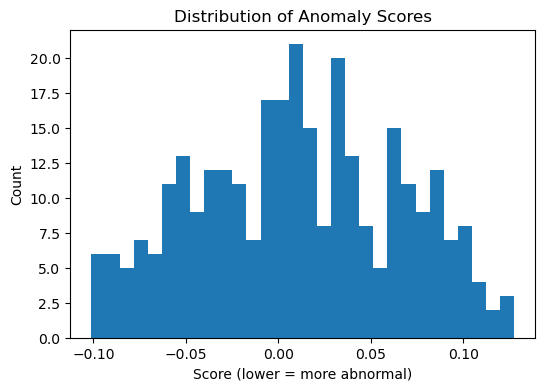

In [77]:
df = df_scaled.copy()

# Separating features & labels
X = df.select_dtypes(include=[np.number]).drop(columns=['condition'], errors='ignore')   
y = df['condition']                  

# Training Isolation Forest only on NORMAL condition 
normal_idx = y == y.min() 
X_normal = X[normal_idx]

iso = IsolationForest(contamination=0.1, random_state=42)
iso.fit(X_normal)

# anomaly scores (lower = more abnormal)
df['anomaly_score'] = -iso.decision_function(X)
df['is_anomaly'] = iso.predict(X)
df['is_anomaly'] = df['is_anomaly'].map({1: 0, -1: 1})  

# Quick check
print(df[['condition','anomaly_score','is_anomaly']])
print("Anomaly count:", df['is_anomaly'].sum())

# Visualization (optional)

plt.figure(figsize=(6,4))
plt.hist(df['anomaly_score'], bins=30)
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Score (lower = more abnormal)")
plt.ylabel("Count")
plt.show()



In [78]:
df.groupby('condition')['is_anomaly'].value_counts().unstack(fill_value=0)

is_anomaly,0,1
condition,,
0,90,10
1,14,86
2,23,77


     condition  anomaly_score  gait_score
0            0      -0.011727   60.896885
1            0      -0.068487   85.724292
2            0      -0.056233   80.364250
3            0      -0.037171   72.026393
4            0      -0.053067   78.979496
..         ...            ...         ...
295          2       0.088917   16.874257
296          2       0.068267   25.906914
297          2       0.071537   24.476783
298          2       0.076967   22.101445
299          2       0.064166   27.700829

[300 rows x 3 columns]

Average Gait Score per Condition:


,condition,gait_score
0,0,75.104330
1,1,42.569326
2,2,36.276367


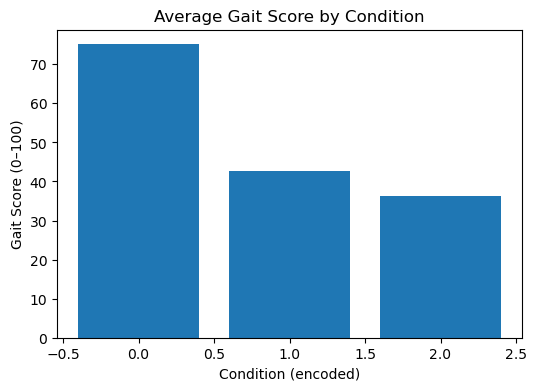

In [79]:
df = df.copy()


scaler = MinMaxScaler(feature_range=(0, 100))

# We invert because lower anomaly_score = more normal in IsolationForest
df['gait_score'] = scaler.fit_transform(-df[['anomaly_score']])

# Quick check
print(df[['condition', 'anomaly_score', 'gait_score']])

# Summary by condition
score_summary = df.groupby('condition')['gait_score'].mean().reset_index()
print("\nAverage Gait Score per Condition:")
display(score_summary)

# Visualization
plt.figure(figsize=(6,4))
plt.bar(score_summary['condition'], score_summary['gait_score'])
plt.title("Average Gait Score by Condition")
plt.xlabel("Condition (encoded)")
plt.ylabel("Gait Score (0–100)")
plt.show()


## GridSearchCV for RandomForest

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

params_rf = {
    'n_estimators': [200, 300, 500],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    rf, param_grid=params_rf, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best RF Params:", grid_rf.best_params_)
print("Best CV Score:", grid_rf.best_score_)
print("Test Accuracy:", best_rf.score(X_test, y_test))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best RF Params: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best CV Score: 0.9833333333333334
Test Accuracy: 0.9333333333333333


- RandomForest

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {acc*100:.2f}%\n")

Random Forest Accuracy: 93.33%



## GridSearchCV for XGBoost

In [82]:
params_xgb = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

grid_xgb = GridSearchCV(
    xgb, param_grid=params_xgb, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_
print("Best XGB Params:", grid_xgb.best_params_)
print("Best CV Score:", grid_xgb.best_score_)
print("Test Accuracy:", best_xgb.score(X_test, y_test))

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best XGB Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9}
Best CV Score: 0.9791666666666666
Test Accuracy: 0.9666666666666667


- XGBOOST

In [83]:
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    random_state=42,
    eval_metric='mlogloss'
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {acc*100:.2f}%\n")

XGBoost Accuracy: 95.00%



## GridSearchCV for SVM

In [84]:
params_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.1, 1]
}

svm = SVC(probability=True, random_state=42)

grid_svm = GridSearchCV(
    svm, param_grid=params_svm, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_
print("Best SVM Params:", grid_svm.best_params_)
print("Best CV Score:", grid_svm.best_score_)
print("Test Accuracy:", best_svm.score(X_test, y_test))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best SVM Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV Score: 0.9958333333333332
Test Accuracy: 0.9666666666666667


- SVM MODEL

In [85]:
svm = SVC(kernel='linear', C=1.0, gamma='scale', probability=True, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {acc*100:.2f}%\n")

SVM Accuracy: 96.67%



## GridSearchCV for LogisticRegression

In [86]:
params_lr = {
    'C': [0.1, 1.0, 10],
    'solver': ['lbfgs', 'saga'],
    'penalty': ['l2', 'l1'],
    'max_iter': [1000, 2000, 3000]
}

lr = LogisticRegression(random_state=42, multi_class='auto')

grid_lr = GridSearchCV(
    lr, param_grid=params_lr, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
print("Best Logistic Regression Params:", grid_lr.best_params_)
print("Best CV Score:", grid_lr.best_score_)
print("Test Accuracy:", best_lr.score(X_test, y_test))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Logistic Regression Params: {'C': 10, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}
Best CV Score: 0.9958333333333332
Test Accuracy: 0.9833333333333333


- Logistic Regression

In [87]:
log_reg = LogisticRegression(C=10, max_iter=2000, solver='saga', penalty='l1', random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {acc*100:.2f}%\n")

Logistic Regression Accuracy: 98.33%



#### overall model's accuracy results

In [88]:
# accuracies of all models
accuracies = {
    "Random Forest": rf.score(X_test, y_test) * 100,
    "XGBoost": xgb.score(X_test, y_test) * 100,
    "SVM": svm.score(X_test, y_test) * 100,
    "Logistic Regression (L1)": log_reg.score(X_test, y_test) * 100
}
for model, acc in accuracies.items():
    print(f"{model:<30}: {acc:.2f}%")


Random Forest                 : 93.33%
XGBoost                       : 95.00%
SVM                           : 96.67%
Logistic Regression (L1)      : 98.33%


## Ensemble

In [89]:
# ensemble
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('svm', svm),
        ('log_reg', log_reg)
    ],
    voting='soft',
    weights=[1, 2, 2, 3]  
)

# Training the ensemble
ensemble.fit(X_train, y_train)

# Predicting
y_pred = ensemble.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {acc*100:.2f}%\n")

Ensemble Accuracy: 98.33%

